In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn import datasets
from sklearn.base import ClassifierMixin, BaseEstimator
from multiprocessing import Pool
import time

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC,SVR
from sklearn.metrics import zero_one_loss


%matplotlib inline

## Bagging

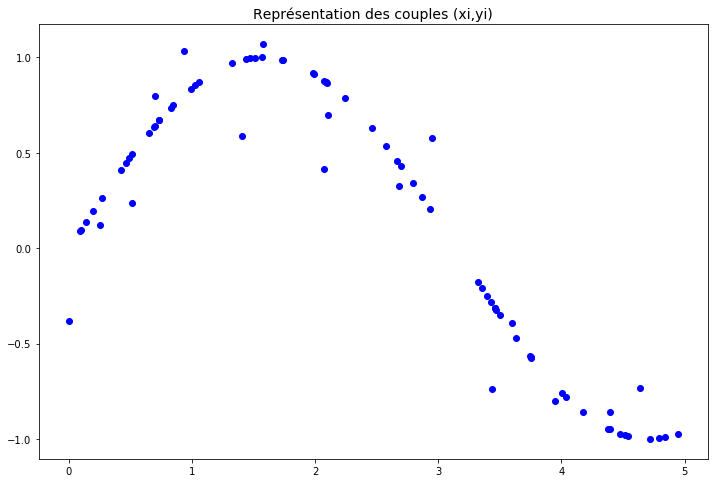

In [2]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 1 * (0.5 - rng.rand(16)) # ajout d'un bruit

n_estimators = 10 # L in the text
tree_max_depth = 10

# Plot the data set
plt.figure(figsize=(12, 8))
plt.plot(X, y, 'bo', label="data")
plt.title("Représentation des couples (xi,yi)",fontsize=14)
plt.show()

In [3]:
#generate train test split
def generate_train_test(nb_points,ratio,bruit):
    rng = np.random.RandomState(1)
    X = np.sort(5 * rng.rand(nb_points, 1), axis=0)
    y = np.sin(X).ravel()
    y[::5] += bruit * (0.5 - rng.rand(1)) # ajout d'un bruit
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=ratio, random_state=42)
    return X_train, X_test, y_train, y_test
    
    

### 1) Mettre en oeuvre le bagging avec des arbres de profondeur 1 puis des arbres plus profonds

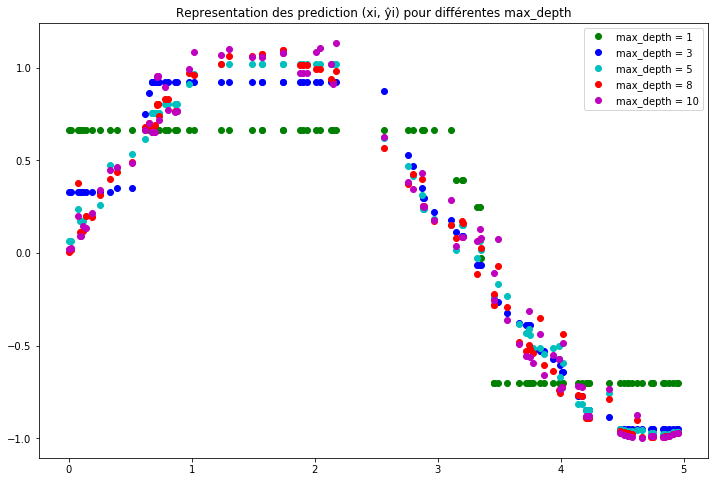

In [4]:
X_train, X_test, y_train, y_test = generate_train_test(500,0.8,1)
max_depth_array = [1,3,5,8,10]
color_palette = ['g','b','c', 'r',  'm', 'y', 'k', 'w']
legend = []

plt.figure(figsize=(12, 8))
for i,depth in enumerate(max_depth_array):
    tree = DecisionTreeRegressor(max_depth=depth)
    #on fixe le nombre d'arbres à 10 afin de s'intéresser uniquement à l'influence de la profondeur
    bagging = BaggingRegressor(base_estimator=tree,n_estimators=10)
    bagging.fit(X_train, y_train)
    y_bagging = bagging.predict(X_test)
    plt.plot(X_test, y_bagging,color_palette[i]+'o', label="bagging tree prediction")
    legend.append("max_depth = "+str(depth))
    #plt.legend(["max_depth = "+str(depth)])
plt.title("Representation des prediction (xi, ŷi) pour différentes max_depth")
plt.legend(legend)

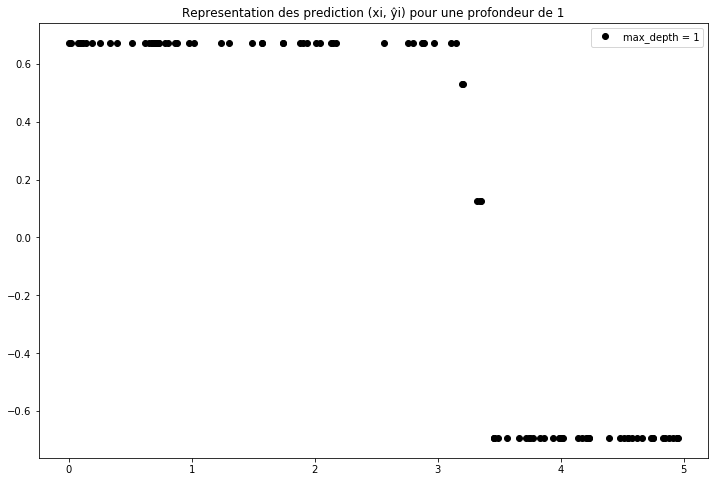

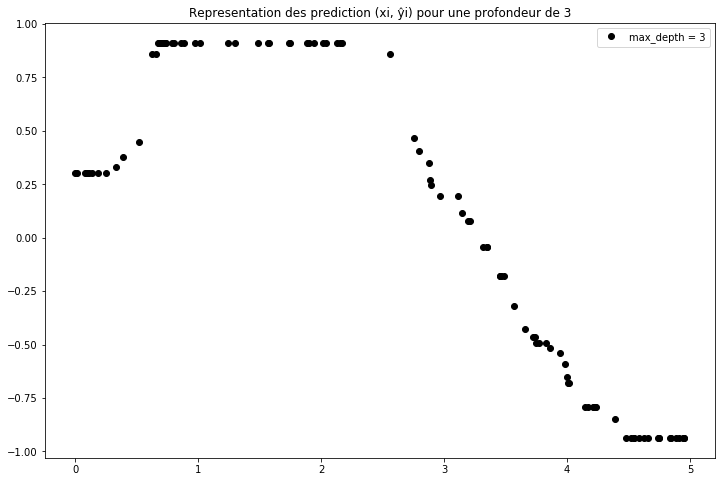

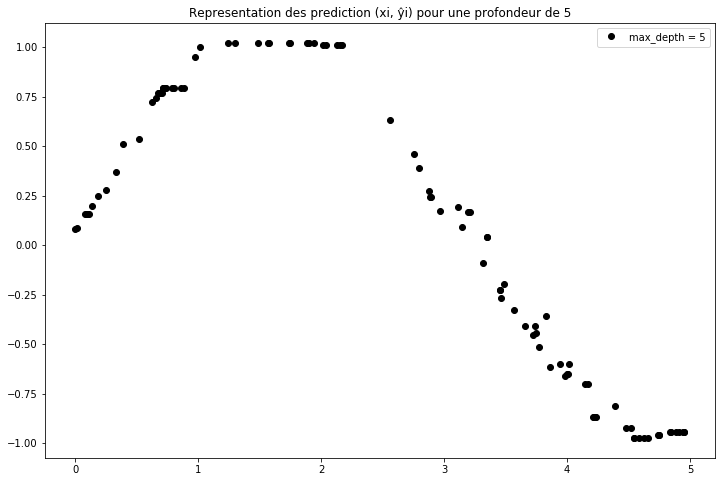

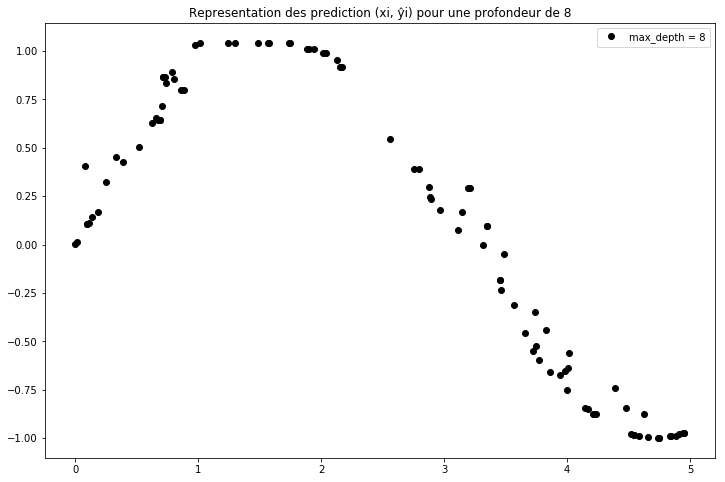

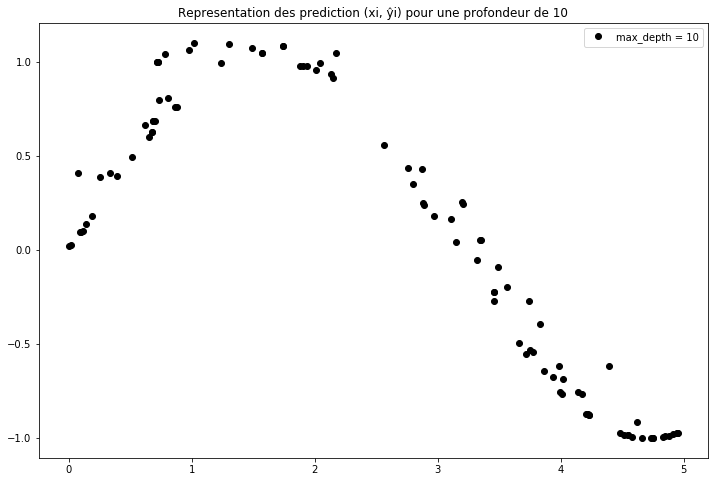

In [5]:
max_depth_array = [1,3,5,8,10]
for i,depth in enumerate(max_depth_array):
    tree = DecisionTreeRegressor(max_depth=depth)
    
    #on fixe le nombre d'arbres à 10 afin de s'intéresser uniquement à l'influence de la profondeur
    bagging = BaggingRegressor(base_estimator=tree,n_estimators=10)
    bagging.fit(X_train, y_train)
    y_bagging = bagging.predict(X_test)
    plt.figure(figsize=(12, 8))
    plt.plot(X_test, y_bagging, 'o',c='k', label="bagging tree prediction")
    plt.legend(["max_depth = "+str(depth)])
    plt.title("Representation des prediction (xi, ŷi) pour une profondeur de "+str(depth))

Le bagging permet de réduire la variance associée à un classifier en augmentant en contrepartie son biais. Il ne sera donc à priori pas performant avec des estimateurs trop peu complexes, à fort biais. On le vérifie ici :

Le nombre d'estimateurs a été fixé à 10.
On constate que la représentation avec une max_depth de 1 underfit largement, plus on augmente la profondeur plus les prédictions semblent coller au train set (on se dirige certainement vers de l'overfit voir Q2).

### 2) Illustrer graphiquement le role max_depth

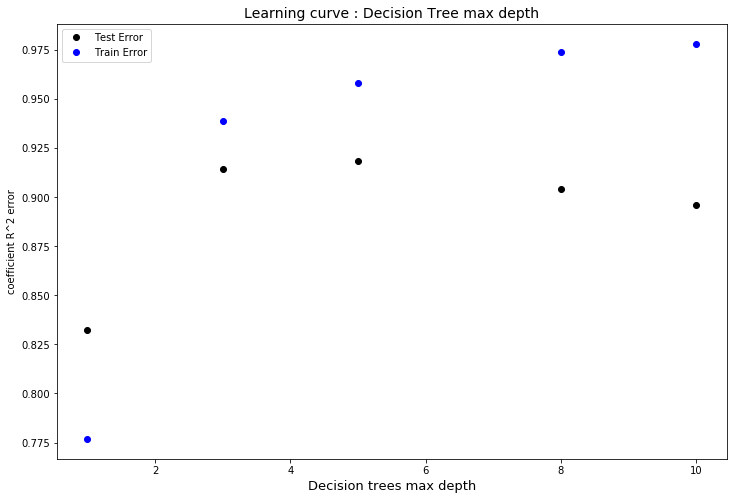

In [6]:
#interessons nous à l'évolution de l'erreur sur le test
score_test = np.zeros(len(max_depth_array))
score_train = np.zeros(len(max_depth_array))
for i,depth in enumerate(max_depth_array):
    tree = DecisionTreeRegressor(max_depth=depth)
    bagging = BaggingRegressor(base_estimator=tree,n_estimators=10)
    bagging.fit(X_train, y_train)
    score_test[i] = bagging.score(X_test,y_test)
    score_train[i] = bagging.score(X_train,y_train)


plt.figure(figsize=(12, 8))
plt.plot(max_depth_array, score_test.tolist(), 'o',c='k')
plt.plot(max_depth_array, score_train.tolist(), 'bo')
plt.xlabel("Decision trees max depth",fontsize=13)
plt.ylabel("coefficient R^2 error")
plt.title("Learning curve : Decision Tree max depth",fontsize=14)
plt.legend(["Test Error","Train Error"])

Le bagging se comporte mieux avec des classifiers complexes jusqu'à une certaine limite, on constate en effet qu'il commence à overfitter pour une max_depth > 5. A noter que j'utilise ici le coefficient R2, plus je suis proche de 1 plus mon modèle est performant.

### 2) Illustrer graphiquement le role de L : nombre d'arbres (max_depth fixée à 5)

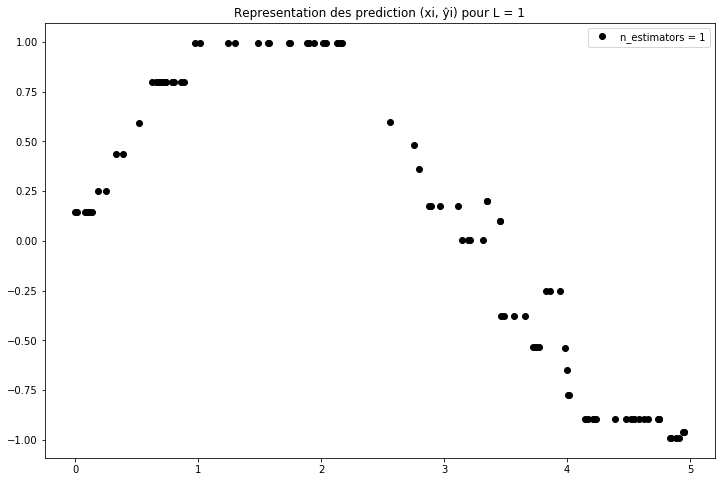

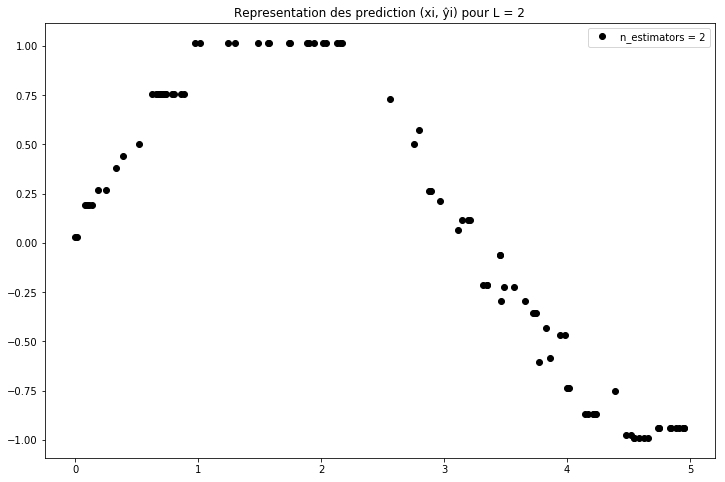

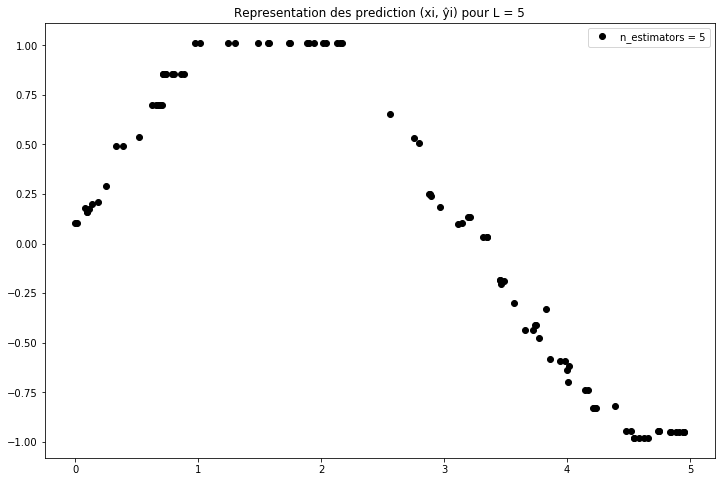

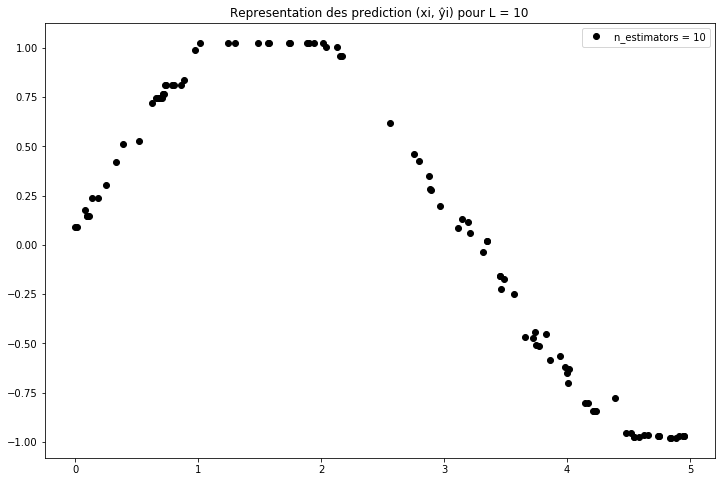

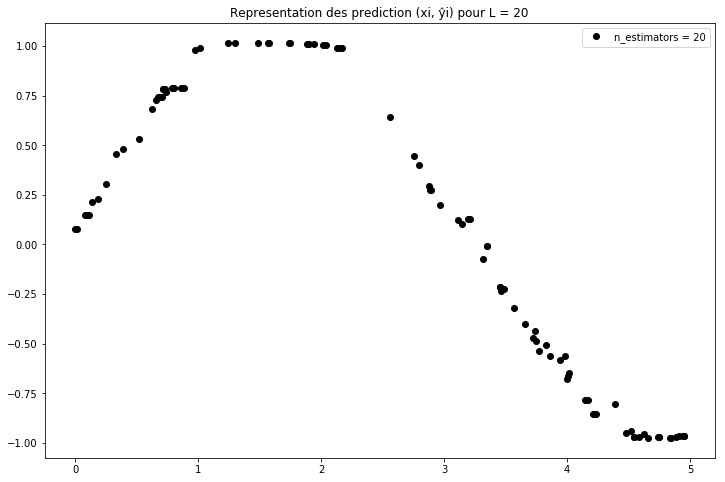

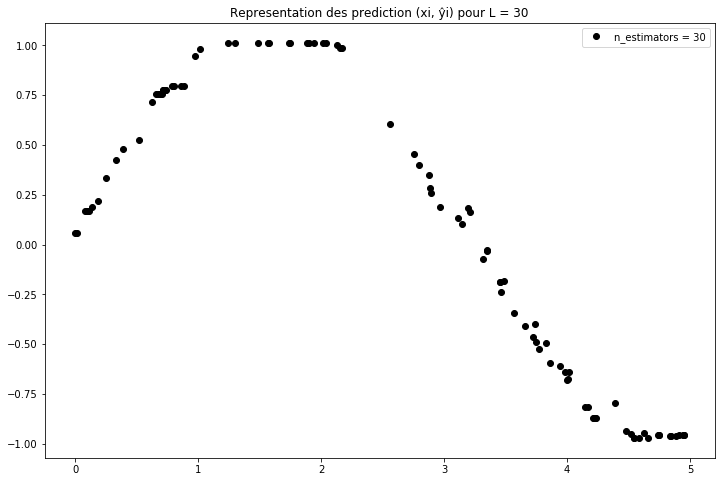

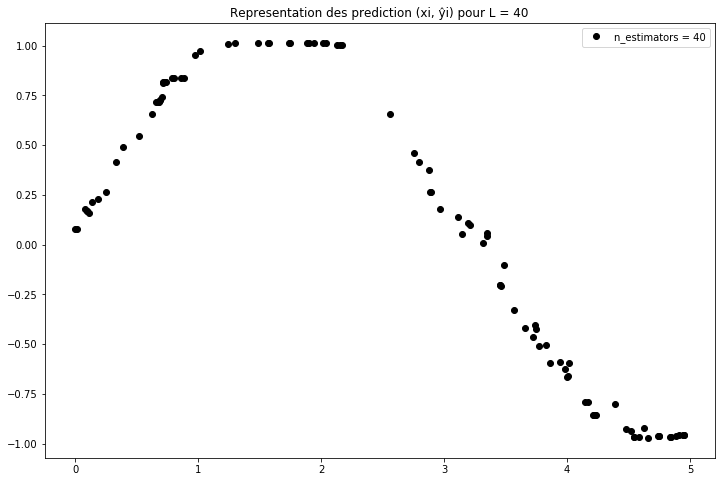

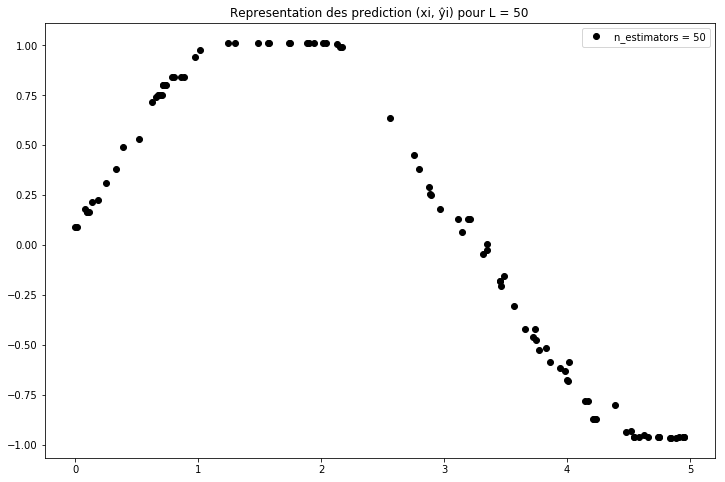

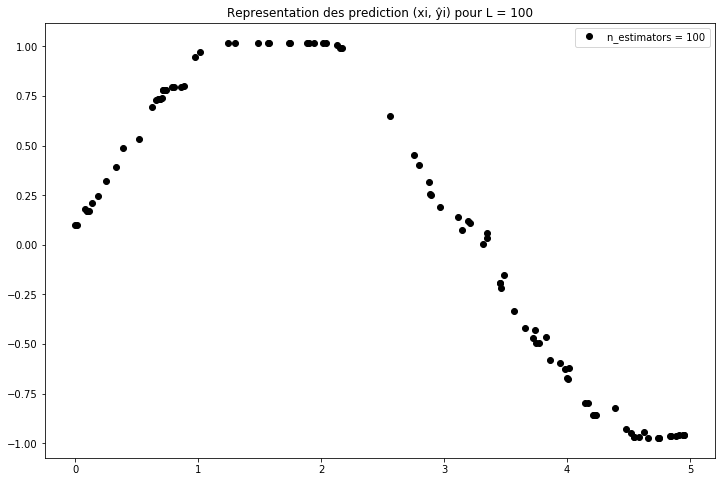

In [7]:
n_estimators = [1,2,5,10,20,30,40,50,100]
for i,n_estim in enumerate(n_estimators):
    #on fixe la profondeur des arbres à 5 pour illustrer l'influence de L
    tree = DecisionTreeRegressor(max_depth=5)
    bagging = BaggingRegressor(base_estimator=tree,n_estimators=n_estim)
    bagging.fit(X_train, y_train)
    y_bagging = bagging.predict(X_test)
    plt.figure(figsize=(12, 8))
    plt.plot(X_test, y_bagging, 'o',c='k', label="bagging tree prediction")
    plt.legend(["n_estimators = "+str(n_estim)])
    plt.title("Representation des prediction (xi, ŷi) pour L = "+str(n_estim))

On constate que plus le nombre d'arbres est grand plus la courbe représentant les prédictions est lisse. On passe d'une représentation continue par morceaux présentant des sauts pour un petit nombre d'arbre à une représentation presque continue pour un très grand nombre d'arbres.
En effet en prenant en compte de plus en plus d'arbres la découpe de l'espace se fait de plus en plus fine, on a donc de moins en moins de sauts brutaux du ŷ en faisant varier un x d'un sous espace à un autre.

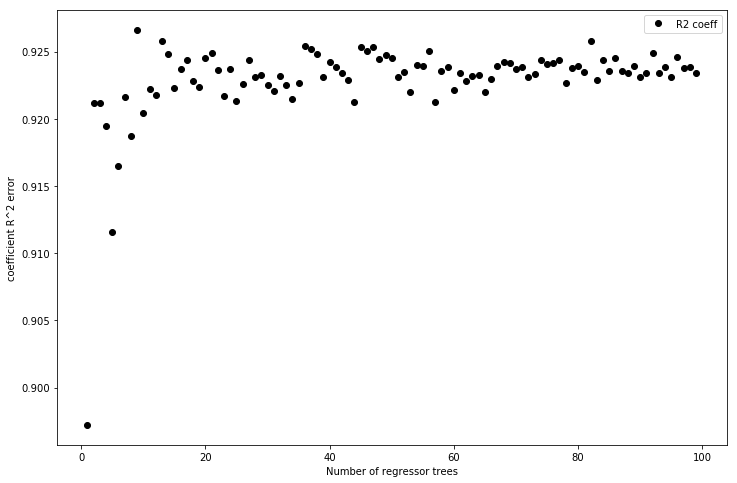

In [8]:
n_estimators = range(1,100,1)
score_test = np.zeros(len(n_estimators))
for i,n_estim in enumerate(n_estimators):
    tree = DecisionTreeRegressor(max_depth=5)
    bagging = BaggingRegressor(base_estimator=tree,n_estimators=n_estim)
    bagging.fit(X_train, y_train)
    score_test[i] = bagging.score(X_test,y_test)


plt.figure(figsize=(12, 8))
plt.plot(n_estimators, score_test.tolist(), 'o',c='k')
plt.ylabel("coefficient R^2 error")
plt.xlabel("Number of regressor trees")
plt.legend(["R2 coeff"])

On constate qu'au dela d'un certains nombre, le paramètre nombre d'arbre n'a plus d'influence sur la performance du modèle.

### 3) A quoi reconnaît-on que les estimateurs construits par les arbres sont biaisés et que le bagging réduit leur variance ?

Les estimateurs sont construits dans le cadre du bagging sur la base d'un sous échantillongage sans remise ou bootstrap des données initiales, les estimateurs pris indépendemment sont alors biaisés vis à vis des données initiales.
Les estimateurs aggrégés seront plus robustes aux petites variations de part leur construction sur des données sous échantillonées, le bagging présente donc une variance plus faible qu'un arbre seul qui aura tendance à trop coller à son train set.

(1000, 1)
(1000, 50)
Tree: 0.1435 (error) = 0.0019 (bias^2)  + 0.0749 (var) + 0.0654 (noise)
Bagging(Tree): 0.0925 (error) = 0.0027 (bias^2)  + 0.0232 (var) + 0.0654 (noise)


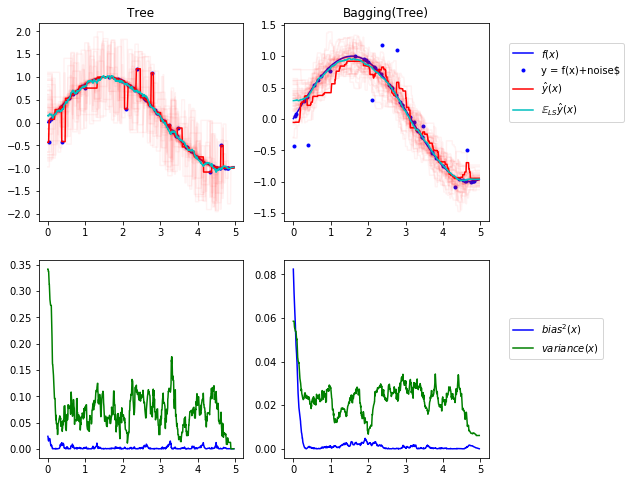

In [10]:
# Settings
n_repeat = 50       
n_train = 50       
n_test = 1000       
noise = 2         
np.random.seed(0)


estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor(),bootstrap=False,max_samples=0.3 ))]

n_estimators = len(estimators)


# Generate data
def f(x):
    x = x.ravel()

    return np.sin(x)


def generate(n_samples, noise, n_repeat=1):
    X = np.sort(5 * rng.rand(n_samples), axis=0)
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X)
        y[::5]+= noise * (0.5 - rng.rand(n_samples//5))
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:,i] = f(X) 
            y[::5,i]+= noise * (0.5 - rng.rand(n_samples//5))

    X = X.reshape((n_samples, 1))
    return X, y

X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)
print(X_test.shape)
print(y_test.shape)
plt.figure(figsize=(10, 8))

# Loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    # Compute predictions
    y_predict = np.zeros((n_test, n_repeat))

    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)   

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    plt.plot(X_train[0], y_train[0], ".b", label="y = f(x)+noise$")

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label="$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    plt.plot(X_test, np.mean(y_predict, axis=1), "c",
             label="$\mathbb{E}_{LS} \^y(x)$")

    #plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    #plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),

    #plt.xlim([-5, 5])
    #plt.ylim([0, 0.1])

    if n == n_estimators - 1:

        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

En se servant du code sklearn pour l'étude du biais et de la variance on constate bien que le bagging permet de réduire la variance. Le biais n'augmente que légèrement sur cet exemple.

### 4) En jouant sur le niveau de bruit mettez en évidence le sur-apprentissage.

In [11]:
def learning_curve_bag (bruit,max_depth_array):
    X_train, X_test, y_train, y_test = generate_train_test(2000,0.7,bruit) 
    
    score_bagging_test = np.zeros(len(max_depth_array))
    score_bagging_train = np.zeros(len(max_depth_array))
    
    for i,depth in enumerate(max_depth_array):
        tree = DecisionTreeRegressor(max_depth=depth)
        bagging = BaggingRegressor(base_estimator=tree,n_estimators=30)
        bagging.fit(X_train, y_train)
        score_bagging_train[i] = bagging.score(X_train, y_train) 
        score_bagging_test[i] = bagging.score(X_test, y_test) 
        
    plt.figure(figsize=(12, 8))
    plt.plot(max_depth_array, score_bagging_test.tolist(), 'o',c='k', label="Error evolution")
    plt.plot(max_depth_array, score_bagging_train.tolist(), 'bo', label="Error evolution")
    plt.ylabel("R2 coeff")
    plt.xlabel("max depth")
    plt.legend(["Test error","Train error"])
    plt.title("Learning curves pour un param bruit de :"+str(bruit))

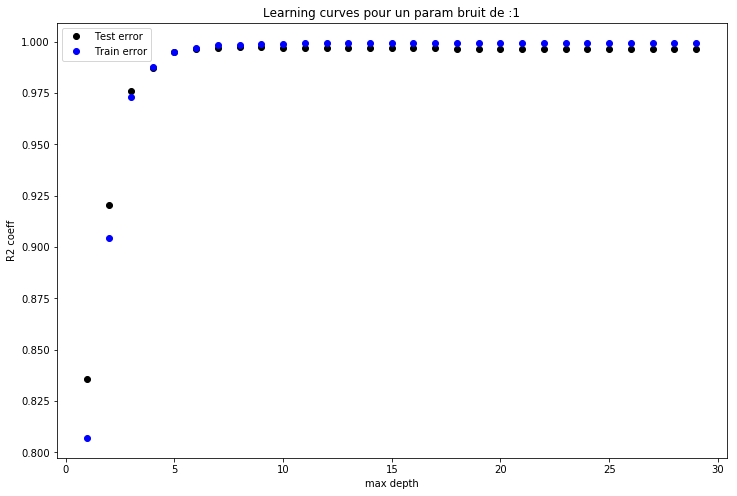

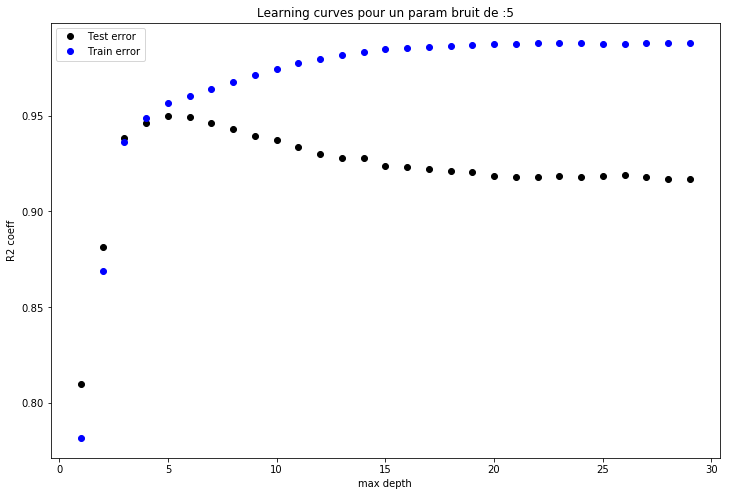

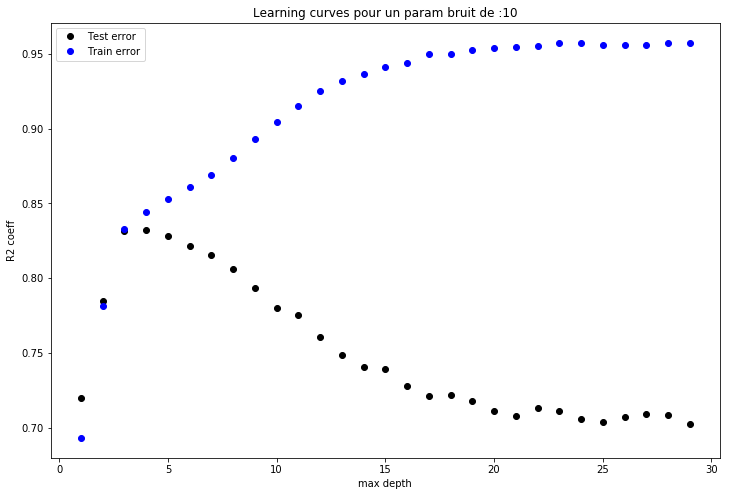

In [12]:
learning_curve_bag(1,max_depth_array = range(1,30,1))
learning_curve_bag(5,max_depth_array = range(1,30,1))
learning_curve_bag(10,max_depth_array = range(1,30,1))

On constate que pour un niveau de bruit conséquent le bagging commence à overfitter au delà d'une certaine profondeur. Même s'il réduit la variance de l'estimateur de base, le sur-apprentissage reste possible avec le bagging, si l'estimateur de base est trop complexe.

### 5) Observer qu’on peut réduire ce phénomène en sous-échantillonnant aléatoirement (sans remise) au lieu de prendre des échantillons bootstrap.

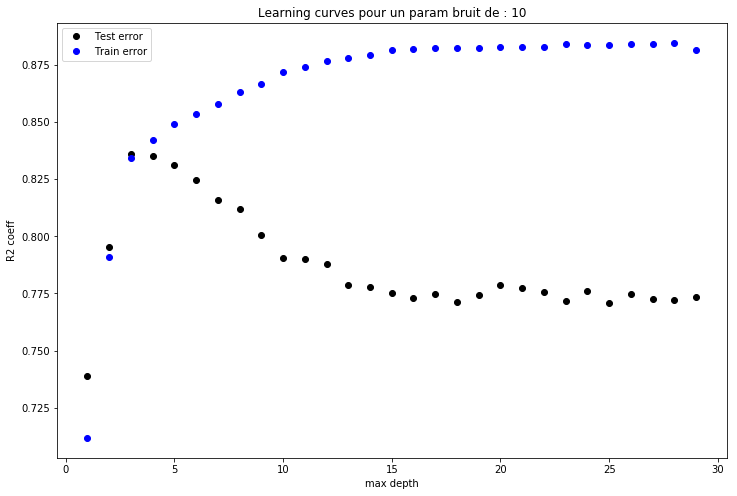

In [13]:
X_train, X_test, y_train, y_test = generate_train_test(2000,0.7,10)
max_depth_array = range(1,30,1)
score_bagging_test = np.zeros(len(max_depth_array))
score_bagging_train = np.zeros(len(max_depth_array))

for i,depth in enumerate(max_depth_array):
    tree = DecisionTreeRegressor(max_depth=depth)
    bagging_no_boot = BaggingRegressor(base_estimator=tree,bootstrap=False,n_estimators=20,max_samples=0.3)
    bagging_no_boot.fit(X_train, y_train)
    score_bagging_train[i] = bagging_no_boot.score(X_train, y_train) 
    score_bagging_test[i] = bagging_no_boot.score(X_test, y_test) 


plt.figure(figsize=(12, 8))
plt.plot(max_depth_array, score_bagging_test.tolist(), 'o',c='k', label="Error evolution")
plt.plot(max_depth_array, score_bagging_train.tolist(), 'bo', label="Error evolution")
plt.ylabel("R2 coeff")
plt.xlabel("max depth")
plt.legend(["Test error","Train error"])
plt.title("Learning curves pour un param bruit de : 10")

On constate en effet qu'avec du sous-échantillonage (nb_echantillons < nb_total) et du tirage sans remise l'effet de sur-apprentissage est atténué, l'écart entre le train et test est moins important que sur la figure ci-dessus.
Néanmoins l'optimum correspondant à une max_depth de 5  présente une performance inférieure que précédemment. On augmente en effet le biais en sous-échantillonnant 

Pourquoi ? Parceque selon la proportion du dataset pris en compte pour chaque tirage sans remise en amont des estimateurs on verra plus ou moins de données que dans le cas du bootstrap (~60%). Dans notre cas on limite à 30% le max_samples donc on verra en moyenne moins de données que dans le cas du bootsrap ce qui a pour effet d'augmenter le biais et diminuer la variance.

## Random Forest

### 6) Évaluez le score par 7-fold cross-validation des Random Forests sur les datasets boston, diabetes, iris et digits. Comparez ces performances avec celles d’un SVM linéaire.

In [14]:
#iris classification (no tuning)
X_iris, y_iris = datasets.load_iris(return_X_y=True)
score_rand_iris = cross_val_score(RandomForestClassifier(),X_iris,y=y_iris,cv=7)
score_svc_iris = cross_val_score(SVC(),X_iris,y=y_iris,cv=7)
print("mean accuracy random forest :",np.mean(score_rand_iris))
print("mean accuracy svc :",np.mean(score_svc_iris))

mean accuracy random forest : 0.946428571429
mean accuracy svc : 0.960034013605


In [15]:
#boston house prices (no tuning)
X_boston, y_boston = datasets.load_boston(return_X_y=True)
score_rand_boston = cross_val_score(RandomForestRegressor(),X_boston,y=y_boston,cv=7)
score_svc_boston = cross_val_score(SVR(),X_boston,y=y_boston,cv=7)
print("mean R2 coeff random forest :",np.mean(score_rand_boston))
print("mean R2 coeff svc :",np.mean(score_svc_boston))

mean R2 coeff random forest : 0.620854181088
mean R2 coeff svc : -0.49988414061


In [16]:
#digits classification  (no tuning)
X_digits, y_digits = datasets.load_digits(return_X_y=True)
score_rand_digits = cross_val_score(RandomForestClassifier(),X_digits,y=y_digits,cv=7)
score_svc_digits = cross_val_score(SVC(),X_digits,y=y_digits,cv=7)
print("mean accuracy random forest :",np.mean(score_rand_digits))
print("mean accuracy svc :",np.mean(score_svc_digits))

mean accuracy random forest : 0.894164022353
mean accuracy svc : 0.441100949059


In [17]:
#diabetes classification (no tuning)
X_diabetes, y_diabetes = datasets.load_diabetes(return_X_y=True)
score_rand_diabetes = cross_val_score(RandomForestRegressor(),X_diabetes,y=y_diabetes,cv=7)
score_svc_diabetes = cross_val_score(SVR(),X_diabetes,y=y_diabetes,cv=7)
print("mean R2 random forest :",np.mean(score_rand_diabetes))
print("mean R2 svr :",np.mean(score_svc_diabetes))

mean R2 random forest : 0.368846450603
mean R2 svr : -0.0487137209614


Vis à vis du SVM (SVC & SVR pour boston) la random forest performe mieux sauf sur le dataset iris. Ici je n'ai pas tuner les estimateurs.

On peut donc constater que contrairement aux estimateurs SVM très sensibles aux tunings de C et gamma, nous obtenons tout de suite de bonnes performances pour la random forest sans tuner le nombre d'estimateurs, le nombre max de features pour chaque split, la profondeur des arbres et/ou le nombre max de samples par split.

Autre avantages du random forest vis à vis du svr/svm :
- parallelisable
- le cout du calcul est moins sensible au nombre d'observations (nécessiter d'effectuer une matrice de gram du Kernel trick dans le cas du SVM, dim n_samples X n_samples

### 7) En utilisant le dataset iris restreint aux deux premières variables explicatives afficher la probabilité de prédiction des classes. On partira du script suivant et on fera varier le nombre d’arbres aléatoires

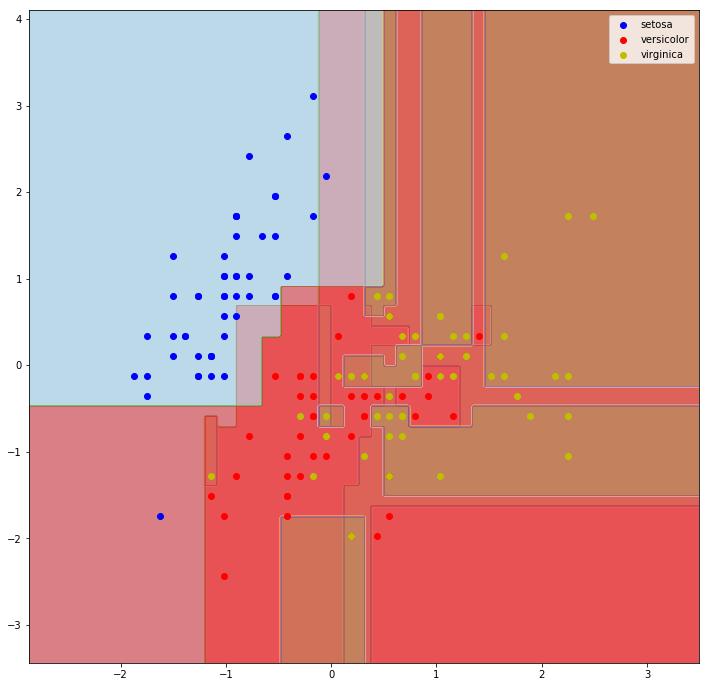

In [18]:
# Parameters
n_estimators = 2
plot_colors = "bry"
plot_step = 0.02

# Load data
iris = datasets.load_iris()
X_unscaled_iris, y_iris = iris.data[:, :2], iris.target

# Standardize
X_iris = preprocessing.scale(X_unscaled_iris)

# RF fitting
model = RandomForestClassifier(n_estimators=n_estimators)
clf = model.fit(X_iris, y_iris)

# Plot the decision boundary
x_1_min, x_1_max = X_iris[:, 0].min() - 1, X_iris[:, 0].max() + 1 #feature 1 parcourue dans son enemble
x_2_min, x_2_max = X_iris[:, 1].min() - 1, X_iris[:, 1].max() + 1 #feature 2 parcourue dans son ensemble
xx_1, xx_2 = np.meshgrid(np.arange(x_1_min, x_1_max, plot_step),np.arange(x_2_min, x_2_max, plot_step))

plt.figure(figsize=(12,12))

for i,tree in enumerate(model.estimators_):
    Z = tree.predict(np.c_[xx_1.ravel(),xx_2.ravel()])
    Z = Z.reshape(xx_1.shape)
    cs = plt.contourf(xx_1, xx_2, Z, alpha=1. / n_estimators, cmap=plt.cm.Paired)
plt.axis("tight")
    # Plot the training points
for i, c in zip(range(3), plot_colors):
    idx = np.where(y_iris == i) #recupere idx pour une classe donnée
    plt.scatter(X_iris[idx, 0], X_iris[idx, 1], c=c, label=iris.target_names[i],
    cmap=plt.cm.Paired) #plot les points correspondant à la classe i
plt.legend(scatterpoints=1)
plt.show()

   

In [19]:
np.transpose(np.vstack((xx_1.ravel(),xx_2.ravel()))).shape == np.c_[xx_1.ravel(),xx_2.ravel()].shape

True

### 8) Comparez les scores par 6-fold cross-validation des Random Forests et des arbres de décisions pures (obtenus avec DecisionTreeClassifier), sur le dataset iris restreint aux deux premières variables explicatives. On fera varier le paramètre max_depth entre 1 et 30. Mettre en évidence le fait que les Random Forests permettent de réduire le sur-apprentissage, et ce même pour des arbres profonds.

In [20]:
X_shuffled,y_shuffled = shuffle(X_unscaled_iris,y_iris)

In [21]:
y_shuffled

array([2, 0, 1, 2, 2, 0, 2, 1, 1, 1, 2, 1, 1, 0, 0, 0, 2, 0, 1, 1, 0, 1, 1,
       2, 1, 0, 2, 0, 2, 1, 2, 2, 1, 1, 1, 1, 1, 0, 0, 2, 2, 1, 0, 2, 2, 2,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 2, 1, 2, 2, 2, 0, 1, 2, 1, 1, 0, 1, 2,
       0, 1, 2, 1, 0, 1, 0, 2, 0, 2, 0, 0, 0, 2, 1, 2, 1, 1, 2, 0, 0, 2, 1,
       0, 2, 0, 0, 1, 1, 2, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 2, 2, 2, 2, 2, 0,
       2, 0, 0, 2, 2, 0, 1, 2, 1, 1, 0, 2, 0, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1,
       0, 2, 0, 2, 2, 2, 1, 0, 1, 1, 0, 0])

In [24]:
max_depth_array = np.arange(1,31)
score_tree = np.zeros(len(max_depth_array))
score_rf = np.zeros(len(max_depth_array))

for i,depth in enumerate(max_depth_array) :
    score_tree[i] = np.mean(cross_val_score(DecisionTreeClassifier(max_depth=depth),X_shuffled,y=y_shuffled,cv=6))
    score_rf[i] = np.mean(cross_val_score(RandomForestClassifier(max_depth=depth,n_estimators=20),\
                                          X_shuffled,y=y_shuffled,cv=6))

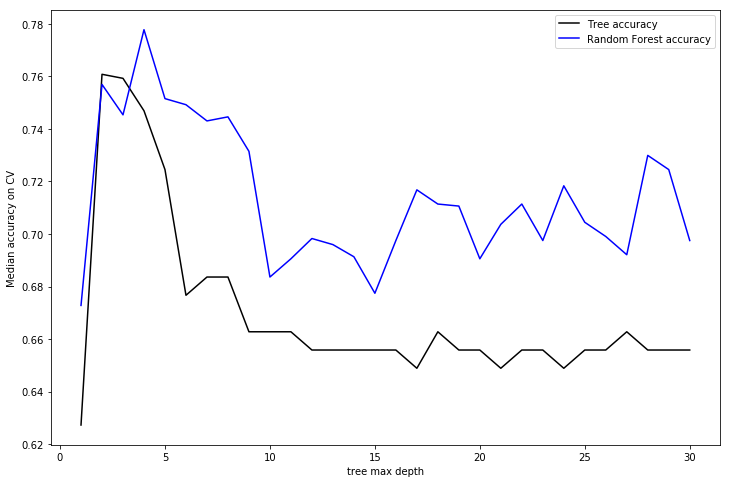

In [25]:
#plot
plt.figure(figsize=(12, 8))
plt.plot(max_depth_array, score_tree.tolist(), '-',c='k')
plt.plot(max_depth_array, score_rf.tolist(), 'b-')
plt.ylabel("Median accuracy on CV")
plt.xlabel("tree max depth")
plt.legend(["Tree accuracy","Random Forest accuracy"])

Lorsque que le max_depth est grand la random forest semble présenter une meilleure accuracy que le Decision Tree. On peut supposer qu'il y a overfitting dans les deux cas au vu de la chute en performance, néanmoins l'overfitting du random forest semble plus atténuée.

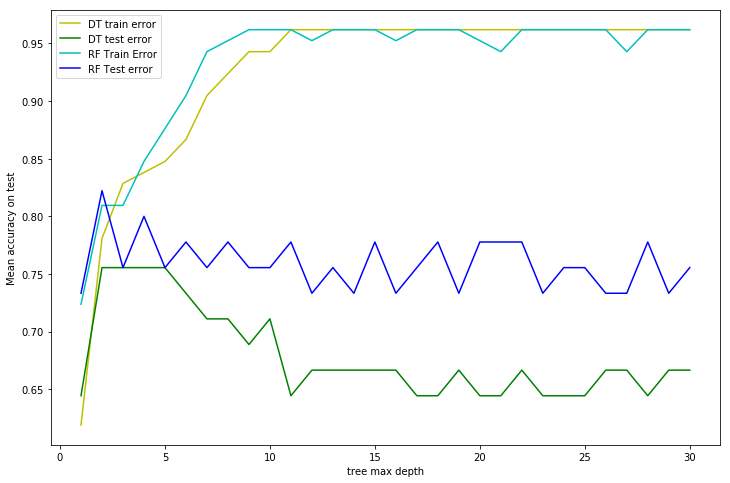

In [26]:
#plot des learning curves
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_unscaled_iris, y_iris, \
                                                                        train_size=0.7, random_state=42)
score_train_tr = np.zeros(len(max_depth_array))
score_test_tr = np.zeros(len(max_depth_array))
score_train_rf = np.zeros(len(max_depth_array))
score_test_rf = np.zeros(len(max_depth_array))

for i,depth in enumerate(max_depth_array) :
    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(X_train_iris,y_train_iris)
    score_train_tr[i] = tree.score(X_train_iris,y_train_iris)
    score_test_tr[i] = tree.score(X_test_iris,y_test_iris)
    
    
    rf = RandomForestClassifier(max_depth=depth,n_estimators=20)
    rf.fit(X_train_iris,y_train_iris)
    score_train_rf[i] = rf.score(X_train_iris,y_train_iris)
    score_test_rf[i] = rf.score(X_test_iris,y_test_iris)

#plot
plt.figure(figsize=(12, 8))
plt.plot(max_depth_array, score_train_tr.tolist(), 'y-')
plt.plot(max_depth_array, score_test_tr.tolist(), 'g-')
plt.plot(max_depth_array, score_train_rf.tolist(), 'c-')
plt.plot(max_depth_array, score_test_rf.tolist(), 'b-')
plt.ylabel("Mean accuracy on test")
plt.xlabel("tree max depth")
plt.legend(["DT train error","DT test error","RF Train Error","RF Test error"])   
    

En traçant les curves on constate que même pour des arbres très profonds la random forest atténue l'effet d'overfitting vis à vis du Decision Tree Classifier : bien que le phénomène d'overfitting existe l'écart entre le train et test score est moins important dans le cas du Random Forest.

## Boosting

### 9) Démontrez la propriété suivante : Le minimiseur de la fonction f -> Rexp(f) = E[exp(-Y f(x))] est atteint en f*(x) = $$\frac{1}{2}*\lg \left ( \frac{\eta \left ( x \right )}{1-\eta \left ( x \right )} \right )$$


D'après Bayes :

$$ E_{X,Y}[exp(-y*f(x))] = E_{X}[E_{Y|X}[exp(-y*f(x))]] $$

Soit $$ f^{\star} (x)$$  minimisant $$E_{Y|X}[exp(-y*f(x))]$$ montrons qu'il minimise aussi $$ E_{X,Y}[exp(-y*f(x))]$$

On sait que :

$$ E_{Y|X}[exp(-Y*f^{\star }(x))] < E_{Y|X}[exp(-Y*f(x))] $$

$$ <=> \int _{Y} exp(-Y*f^{\star }(x))dP_{Y|X} < \int _{Y} exp(-Y*f(x))dP_{Y|X}  $$

L'intégrale conserve le sens des inégalités :

$$ <=> \int _{X}\int _{Y} exp(-Y*f^{\star }(x))dP_{Y|X} dP_{X}< \int _{X}\int _{Y} exp(-Y*f^(x))dP_{Y|X} dP_{X} $$

Il "suffit" donc de minimiser :  $$E_{Y|X}[exp(-y*f(x))]$$

$$ E\left ( \exp \left ( -y*f\left ( x \right ) \right ) \right |X=x)) = P(y=1|X=x)*\exp \left ( -f\left ( x \right ) \right ) + P(y=-1|X=x)*\exp \left ( f\left ( x \right ) \right )$$

exp(−y∗f(x)) est convexe, donc pour trouver le f(x) minimisant E(exp(−y∗f(x))||X=x)), on calcule la dérivée partielle par rapport à f(x), et on pose cette dérivée égale à 0

$$ -P(y=1|X=x)*\exp (-f\left ( x \right )) + P(y=1|X=x)*\exp \left ( f\left ( x \right ) \right ) = 0 $$

On remplace par η(x)

$$ \eta \left ( x \right )*exp(-f(x)) =  (1-\eta \left ( x \right ))*exp(f(x)) $$

On passe par le log :

$$ f(x) = \frac{1}{2}*log\left ( \frac{\eta \left ( x \right )}{1-\eta \left ( x \right )} \right ) $$

### 10) En déduire que le classifieur de Bayes associé au risque Rexp est le même que le classifieur de Bayes associé au risque 0/1

f(x) s'annule pour η(x)=0.5, elle est positive si η(x)>0.5, négative sinon

On en déduit que le classifier associé à f(x) minimisant le Rexp : sign(f(x)), est le classifier de bayes

### 11) Montrer que la solution du dernier programme d’optimisation est : cm = $$c_{m} = \frac{1}{2} * log\left ( \frac{P(Y=h_{m}(x)|w_{m-1})}{P(Y\neq h_{m}(x)|w_{m-1})} \right )$$

$$ E_{w^{m-1}}[exp(-c*Y*h_{m}(x))] = \sum _{i=1}^{n}w^{m-1}_{i}exp(-c*Y*h_{m}(x))$$

Afin de trouver le c minimisant l'espérance, dérivons par rapport à c, posons la dérivée égale à 0 (convexité du risque exponentiel) :

$$ \sum _{i:y_{i}=h_{m}(x_{i})}w_{i}^{m-1}exp(-c) = \sum _{i:y_{i}\neq h_{m}(x_{i})}w^{m-1}_{i}exp(c) $$

$$ <=> P_{w_{i}^{m-1}}(y=h_{m}(x)) * exp(-c) = P_{w_{i}^{m-1}}(y\neq h_{m}(x)) * exp(c) $$

En passant par le logarithme : 

$$c_{m} = \frac{1}{2} * log\left ( \frac{P(Y=h_{m}(x)|w_{m-1})}{P(Y\neq h_{m}(x)|w_{m-1})} \right )$$

### 12)  Montrer que les poids ..

### 13) Mettre en oeuvre AdaBoost avec des arbres de profondeur 1, puis 2, puis 10, sur le jeu de données digits. On calculera notamment la précision obtenue par 6-fold cross-validation.

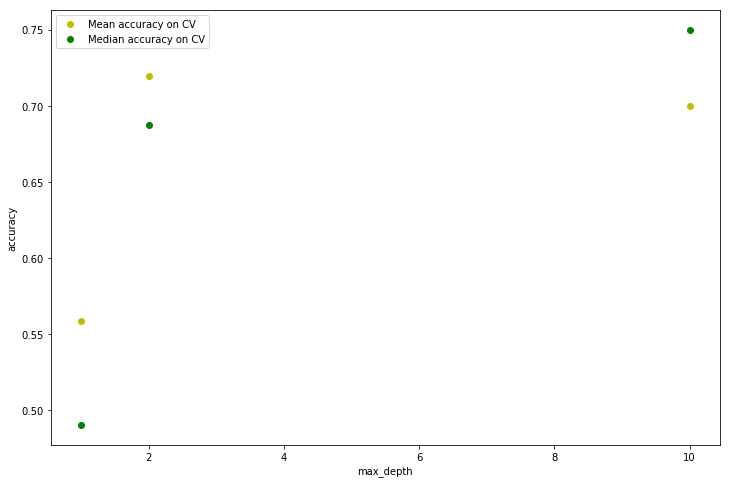

In [27]:
max_depth_array = [1,2,10]
scores_mean = np.zeros(len(max_depth_array))
scores_med = np.zeros(len(max_depth_array))

for i,depth in enumerate(max_depth_array) :
    adab = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth))
    scores_mean[i] = np.mean(cross_val_score(adab,X_unscaled_iris,y_iris,scoring='accuracy'))
    scores_med[i] = np.median(cross_val_score(adab,X_unscaled_iris,y_iris,scoring='accuracy'))

#plot
plt.figure(figsize=(12, 8))
plt.plot(max_depth_array, scores_mean.tolist(), 'yo')
plt.plot(max_depth_array, scores_med.tolist(), 'go')
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend(["Mean accuracy on CV","Median accuracy on CV"])

### 14) Appliquer AdaBoost sur les données digits découpées en deux échantillons : apprentissage (75%) et test (25%). Tracer les erreurs (0/1) d’apprentissage et de test en fonction du nombre d’itérations.

In [28]:
def learning_curve_boost(n,depth,X_train,X_test,y_train,y_test):
    adab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth),n_estimators=n)
    adab.fit(X_train,y_train)
    
    #get the prediction stagewise
    ada_real_err = np.zeros((n))
    for i, y_pred in enumerate(adab.staged_predict(X_test)):
        #compute test error of stagewise predictions
        ada_real_err[i] = zero_one_loss(y_pred, y_test)

    ada_real_err_train = np.zeros((n))
    for i, y_pred in enumerate(adab.staged_predict(X_train)):
        #compute train error of stagewise predictions
        ada_real_err_train[i] = zero_one_loss(y_pred, y_train)
    
    #plot
    plt.figure(figsize=(12, 8))
    plt.plot(np.arange(n) + 1, ada_real_err,color='orange')
    plt.plot(np.arange(n) + 1, ada_real_err_train,color='green')
    print(ada_real_err)
    plt.legend(["Test error depth :"+str(depth),"Train error depth : "+str(depth)])
    plt.title("Learning curves AdaBoost de Trees de depth : "+str(depth))

[ 0.82        0.72888889  0.68222222  0.68222222  0.68444444  0.68444444
  0.68444444  0.68444444  0.68444444  0.68444444  0.68444444  0.68444444
  0.68444444  0.68444444  0.68444444  0.68444444  0.68444444  0.68444444
  0.68444444  0.68444444  0.68444444  0.68444444  0.68444444  0.68444444
  0.68444444  0.68444444  0.68444444  0.68444444  0.68444444  0.68444444
  0.68444444  0.68444444  0.68444444  0.68444444  0.68444444  0.68444444
  0.68444444  0.68444444  0.68444444  0.68444444  0.68444444  0.68444444
  0.68444444  0.68444444  0.68444444  0.68444444  0.68444444  0.68444444
  0.68444444  0.68444444]


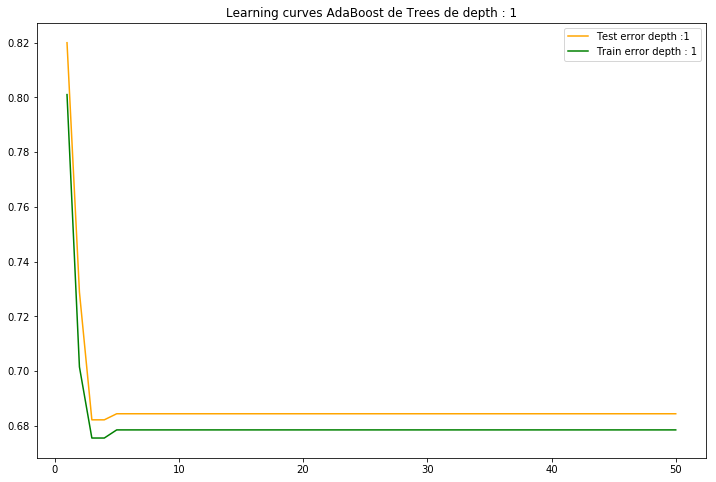

In [29]:
#plot des learning curves
X_train_digits, X_test_digits, y_train_digits, y_test_digits = train_test_split(X_digits, y_digits, \
                                                                        train_size=0.75, random_state=5)
learning_curve_boost(50,1,X_train_digits, X_test_digits, y_train_digits, y_test_digits)

[ 0.69111111  0.55333333  0.56        0.43777778  0.38444444  0.38888889
  0.37333333  0.36888889  0.34444444  0.34444444  0.34888889  0.34666667
  0.35111111  0.34888889  0.35111111  0.35111111  0.32        0.38
  0.34666667  0.34        0.34222222  0.35555556  0.34888889  0.35333333
  0.34222222  0.30666667  0.32222222  0.32222222  0.31333333  0.34
  0.34666667  0.29555556  0.32        0.32        0.28222222  0.31555556
  0.32222222  0.31777778  0.31111111  0.30222222  0.30222222  0.30666667
  0.31111111  0.30666667  0.30666667  0.31333333  0.30222222  0.30666667
  0.29777778  0.29777778]


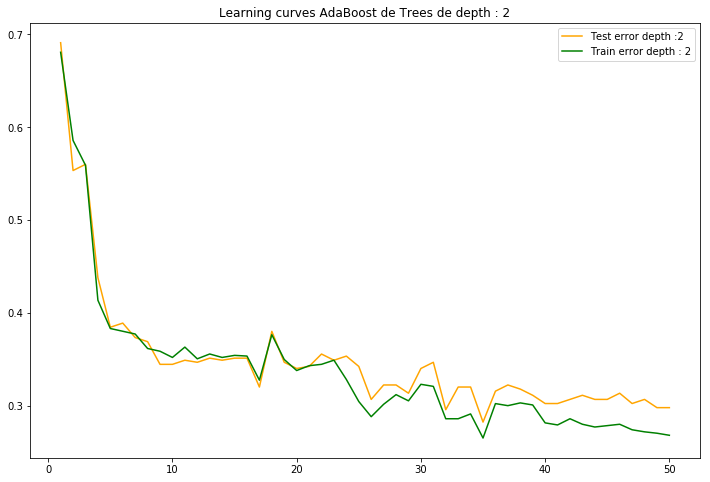

In [30]:
learning_curve_boost(50,2,X_train_digits, X_test_digits, y_train_digits, y_test_digits)

[ 0.32666667  0.3         0.25111111  0.21777778  0.19777778  0.16
  0.12444444  0.11111111  0.10444444  0.10666667  0.10666667  0.10666667
  0.11333333  0.10444444  0.09333333  0.10222222  0.09333333  0.08888889
  0.09111111  0.08444444  0.08444444  0.08666667  0.08444444  0.09111111
  0.08        0.08        0.07777778  0.07777778  0.07333333  0.07555556
  0.07555556  0.07111111  0.06888889  0.07111111  0.06222222  0.05777778
  0.05777778  0.06222222  0.06444444  0.06444444  0.06666667  0.06666667
  0.06222222  0.05777778  0.05777778  0.06444444  0.06222222  0.06
  0.06222222  0.06      ]


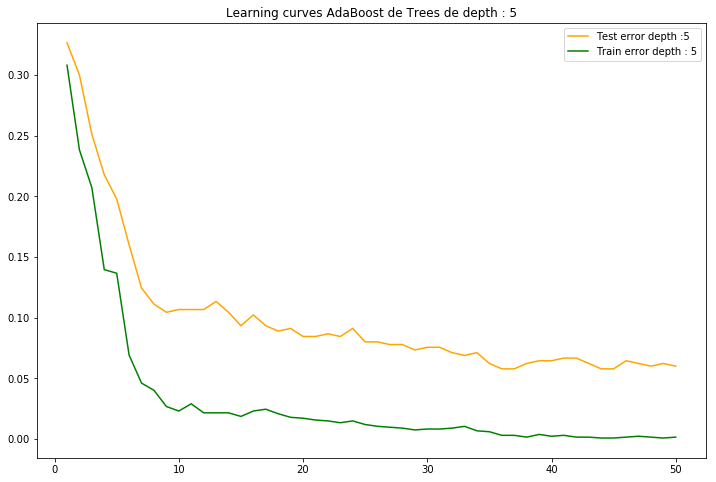

In [31]:
learning_curve_boost(50,5,X_train_digits, X_test_digits, y_train_digits, y_test_digits)

[ 0.16222222  0.16444444  0.12444444  0.10888889  0.08444444  0.08
  0.07555556  0.05111111  0.06        0.05333333  0.04666667  0.04
  0.04666667  0.04222222  0.03777778  0.03555556  0.03555556  0.03333333
  0.03333333  0.02666667  0.02444444  0.02888889  0.02444444  0.02444444
  0.02222222  0.02222222  0.02222222  0.02222222  0.02222222  0.02222222
  0.02        0.02        0.02        0.02        0.02        0.02        0.02
  0.02        0.02222222  0.02222222  0.02444444  0.02222222  0.02444444
  0.02444444  0.02444444  0.02222222  0.02222222  0.02222222  0.02222222
  0.02222222]


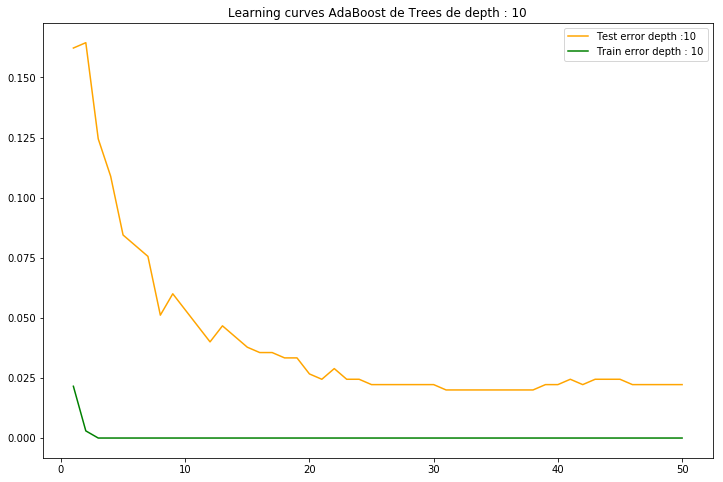

In [32]:
learning_curve_boost(50,10,X_train_digits, X_test_digits, y_train_digits, y_test_digits)

### 15) Que remarquez vous ? Que se passe-t-il si la profondeur des arbres de classification est grande ?

On remarque qu'au dela d'une certaine profondeur l'erreur sur le train devient nulle. On pourrait alors penser qu'on overfit pourtant sur ce jeu de données l'erreur sur le test continue de diminuer.
L'algorithme ne semble pas overfitter sur le jeu de données digits, sachant que l'overfitting reste possible avec le boosting on peut penser que le comportement observé est lié au jeu de données. Ainsi le jeu de données digit semble être parfaitement séparable : on obtient une erreur quasi nulle pour un max_depth supérieur à 20.

### 16) Implementer votre algorithme AdaBoost

In [52]:
class myAdaBoost (BaseEstimator,ClassifierMixin):
    def __init__(self,depth,n_estimators):
        self.depth = depth
        self.n_estimators = n_estimators
        self.estimators_list = []
        self.cm = np.zeros(self.n_estimators)
    
    def fit(self,X,y):
        #initialisation des poids : 1/n
        w = np.ones(X.shape[0]) * (1/X.shape[0])
   
        for i in range(0,self.n_estimators):
            #ALGORITHM
            #apply weight distrbution to the datas
            estimator = DecisionTreeClassifier(max_depth=self.depth)
            estimator.fit(X,y,sample_weight=w) 
            y_pred = estimator.predict(X) 
            print("score :"+str(estimator.score(X,y)))
            self.estimators_list.append(estimator)
            
            #indicatrice : 1 missclassified 0 otherwise
            indicatrice = np.zeros(X.shape[0])
            indicatrice[y_pred != y] = 1  
            
            #compute cm
            prob_missclass = np.dot(np.transpose(w.reshape(-1,1)),indicatrice.reshape(-1,1))
            prob_wellclass = np.dot(np.transpose(w.reshape(-1,1)),(1-indicatrice.reshape(-1,1)))
            self.cm[i] = (1/2) * np.log(prob_wellclass/prob_missclass)
            print("cm :"+str(self.cm[i]))
            #weight update
            w_interm = w * np.exp(2*self.cm[i]*indicatrice)
            #passage à l'échelle : somme w = 1
            w = w_interm / np.sum(w_interm)
        
        return self
    
            
    def predict(self,X):
        #based on a weighted majority vote of the classifier list
        pred_matrix = np.zeros((X.shape[0],self.n_estimators)) #store all predictions
        
        #make predictions for all classifiers
        for j in range(0,self.n_estimators): 
            pred_matrix[:,j] = self.estimators_list[j].predict(X)    
        
        #matrix for the vote
        classes = np.unique(pred_matrix)
        res_matrix = np.zeros((X.shape[0],classes.shape[0]))
        
        #weighted vote
        for i in range(0,(X.shape[0])):
            for j,classe in enumerate(classes):
                idx = np.where(pred_matrix[i] == j)
                if len(idx[0])>0:
                    res_matrix[i,j] = np.dot(np.ones((1,len(idx[0]))),self.cm[idx[0]])
                else:
                    res_matrix[i,j] = 0
        
        
        #on prend le compte max pour chaque ligne et on return la classe associée
        idx = np.argmax(res_matrix,axis=1)
        y_pred = np.array([classes[idx[i]] for i in range(0,idx.shape[0])])
        return y_pred
    
    def score(self,X,y):
        return np.mean(self.predict(X)==y)
                        
        
    

Test avec une profondeur de 4

In [62]:
my_adab = myAdaBoost(4,3)
my_adab.fit(X_train_digits,y_train_digits)

score :0.590942835932
cm :0.183932188346
score :0.701559020045
cm :0.40125274242
score :0.657757980698
cm :0.306930200011


myAdaBoost(depth=4, n_estimators=3)

In [63]:
my_adab.score(X_test_digits,y_test_digits)

0.71999999999999997

In [64]:
adab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4),n_estimators=3)
adab.fit(X_train_digits,y_train_digits)
adab.score(X_test_digits,y_test_digits)

0.62666666666666671

Test avec une profondeur de 3

In [65]:
my_adab = myAdaBoost(3,3)
my_adab.fit(X_train_digits,y_train_digits)

score :0.473645137342
cm :-0.0527586215937
score :0.473645137342
cm :3.33066907388e-16
score :0.473645137342
cm :-1.11022302463e-16


myAdaBoost(depth=3, n_estimators=3)

On constate qu'avec une profondeur de 3, aucun estimateur n'est meilleur qu'une pièce de monnaie (accuracy < 0.50), l'estimateur maison ne donnera donc pas de résultats concluants : il est possible que les algos ne se recoupent pas sur leurs prédictions.

Néanmoins l'estimateur de sklearn est toujours performant.

In [61]:
adab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=3)
adab.fit(X_train_digits,y_train_digits)
adab.score(X_test_digits,y_test_digits)

0.5377777777777778